In [1]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from RL_utils import *
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn import svm
import numpy as np

import os
from JSAnimation import IPython_display
from matplotlib import animation
import cv2
import imageio
import mpld3
import scipy.misc

In [2]:
figurePath = 'F:\STUDY\MS Cognitive Science IITD\Internship\RTG Computational Cognition\Code/Results/'

## See EXT+ INT Model Predictions for Next state VS Actual Encodings for the state 

### Loading predicted and truth encoded states

In [3]:
pred_next_states_ExtInt = np.load('models\ext+int\\4000_0\\pred_state.npy')
# pred_next_states_Int = pred_next_states_Int.reshape(7804,128)

#removing last pred
pred_next_states_ExtInt = pred_next_states_ExtInt[:-1]
pred_next_states_ExtInt.shape

(3999, 1, 256)

In [4]:
cur_state_ExtInt = np.load('models\ext+int\\4000_0\\\enc_cur_state.npy')
# cur_state_Int = pred_next_states_Int.reshape(7804,128)

#moving current frames by one
cur_state_ExtInt = cur_state_ExtInt[1:]    

In [5]:
curiosity_encoding_nextstate_ExtInt = cur_state_ExtInt
curiosity_encoding_nextstate_ExtInt.shape

(3999, 1, 256)

### Visual Observations

In [6]:
enc1 = np.load('models\ext+int\\4000_0\\visobs.npy')
enc1.shape

(4000, 168, 168, 3)

### Forward Model Loss

In [7]:
import tensorflow as tf
curiosity_strength=1.0
def create_forward_model(pred_state, encoded_next_state):
#         encoded_next_state
        """
        gives forward loss for Curiosity module.
        :param pred_state: Tensor corresponding to predicted next state.
        :param encoded_next_state: Tensor corresponding to encoded next state.
        """
        
        squared_difference = 0.5 * tf.reduce_sum(tf.compat.v1.squared_difference(pred_state, encoded_next_state), axis=1)
        intrinsic_reward = tf.clip_by_value(curiosity_strength * squared_difference, 0, 1)
#         forward_loss = tf.reduce_mean(squared_difference)
        forward_loss = tf.reduce_mean(tf.dynamic_partition(data=squared_difference,partitions=[1]
                                                           ,num_partitions=2)[1])
        
        return forward_loss

forward_losses = []
for i in range(0,3999):
    forward_loss = create_forward_model(pred_next_states_ExtInt[i], curiosity_encoding_nextstate_ExtInt[i])
    forward_losses.append(np.array(forward_loss))
    
print(forward_losses)

[array(0.12889202, dtype=float32), array(0.01298087, dtype=float32), array(0.00560872, dtype=float32), array(0.0064639, dtype=float32), array(0.00542163, dtype=float32), array(0.00740195, dtype=float32), array(0.01188449, dtype=float32), array(0.02469852, dtype=float32), array(0.02386558, dtype=float32), array(0.00960027, dtype=float32), array(0.01967124, dtype=float32), array(0.02608936, dtype=float32), array(0.03034176, dtype=float32), array(0.05091503, dtype=float32), array(0.3767315, dtype=float32), array(0.391919, dtype=float32), array(0.9064034, dtype=float32), array(0.53318655, dtype=float32), array(0.07974283, dtype=float32), array(0.19048052, dtype=float32), array(0.02314126, dtype=float32), array(0.007399, dtype=float32), array(0.03183697, dtype=float32), array(0.00682916, dtype=float32), array(0.0115644, dtype=float32), array(0.00728929, dtype=float32), array(0.00448232, dtype=float32), array(0.01060577, dtype=float32), array(0.00580079, dtype=float32), array(0.00951893, dty

### Inverse Model Loss

In [8]:
pred_action_ExtInt = np.load('models\ext+int\\4000_0\\pred_act.npy')
#removing last pred
pred_action_ExtInt = pred_action_ExtInt[1:]
pred_action_ExtInt.shape

(3999, 1, 11)

In [9]:
from numpy import argmax
pred_action_argmax_ExtInt = [0]*3999
for index,act in enumerate(pred_action_ExtInt):
    
        act_1 = argmax(act[0][0:3])
        act_2 = argmax(act[0][3:6])
        act_3 = argmax(act[0][6:8])
        act_4 = argmax(act[0][8:11])
        
        pred_action_argmax_ExtInt[index] = np.array([[act_1,act_2,act_3,act_4]],dtype=int)
        
pred_action_argmax_ExtInt[:6]

[array([[1, 1, 0, 1]]),
 array([[1, 1, 0, 1]]),
 array([[1, 1, 0, 1]]),
 array([[1, 1, 0, 1]]),
 array([[1, 1, 0, 1]]),
 array([[1, 1, 0, 1]])]

In [10]:
selected_action_ExtInt = np.load('models\ext+int\\4000_0\\actions.npy')
#moving current frames by one
selected_action_ExtInt = selected_action_ExtInt[1:]  
selected_action_ExtInt.shape
# selected_action_Int[:5]

(3999, 1, 4)

In [11]:
act_size = [3,3,2,3]
def create_inverse_model(pred_actions,selected_actions):
        """
        gives inverse loss for Curiosity module.
        :pred_actions: Tensor corresponding to predicted action.
        :param encoded_next_state: selected action.
        """
        #trial - LOSS AS CALCULATED IN MLAGENTSDEV/TRAINERS/BC/MODELS.PY
#         action_oh = tf.concat([
#                 tf.one_hot(selected_actions[:, i], act_size[i]) for i in range(len(act_size))], axis=1)
#         inverse_loss = tf.reduce_sum(-tf.compat.v1.log(pred_actions + 1e-10) * action_oh)
        
        # original
        cross_entropy = tf.reduce_sum(-tf.compat.v1.log(pred_actions + 1e-10) * selected_actions, axis=1)
        inverse_loss = tf.reduce_mean(tf.dynamic_partition(cross_entropy, [1], 2)[1])
        
        return inverse_loss
    
inverse_losses = []
for i in range(0,3999):
#     inverse_loss = create_inverse_model(pred_action_Int[i], selected_action_Int[i])
    inverse_loss = create_inverse_model(pred_action_argmax_ExtInt[i], selected_action_ExtInt[i])
    inverse_losses.append(np.array(inverse_loss))
    
print(inverse_losses)

[array(-3.00000025e-10), array(-3.00000025e-10), array(-3.00000025e-10), array(-3.00000025e-10), array(-3.00000025e-10), array(-2.00000017e-10), array(-2.00000017e-10), array(-2.00000017e-10), array(-2.00000017e-10), array(46.05170186), array(-2.00000017e-10), array(-2.00000017e-10), array(-3.00000025e-10), array(-5.00000041e-10), array(45.35855468), array(-1.38629436), array(-1.38629436), array(-2.77258872), array(-1.38629436), array(-3.00000025e-10), array(-3.00000025e-10), array(-4.00000033e-10), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-0.69314718), array(-4.00000033e-10), array(-1.38629436), array(-0.69314718), array(-3.00000025e-10), array(-3.00000025e-10), array(-4.00000033e-10), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-1.38629436), array(-0.69314718), array(-2.00000017e-10), array(-2.00000017e-10), array(23.02

### Vector Observations

In [12]:
vecobs = np.load('models\ext+int\\4000_0\\vecobs.npy')
vecobs.shape
# vecobs[0]

(1, 4000, 8)

In [13]:
keys=[]
time_left = []
levels=[]

for f in vecobs[0][1:]:
    for index,i in enumerate(f[:6]):
        if i==1:
            keys.append(index)
    
    time_left.append(f[6])
    
    levels.append(f[7])
    
print(len(keys),len(time_left),len(levels))
# print(keys)

# for f in vecobs:
#     print(f[0])

3999 3999 3999


## Plotting heatmap of predicted and truth encodings, visual and vector observations, forward and inverse losses

C:\Users\Varad Srivastava\Anaconda3\lib\site-packages\JSAnimation\html_writer.py:282: MatplotlibDeprecationWarning: 
The 'clear_temp' parameter of setup() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'clear_temp', they should be passed as keyword, not positionally.
  frame_prefix, clear_temp=False)



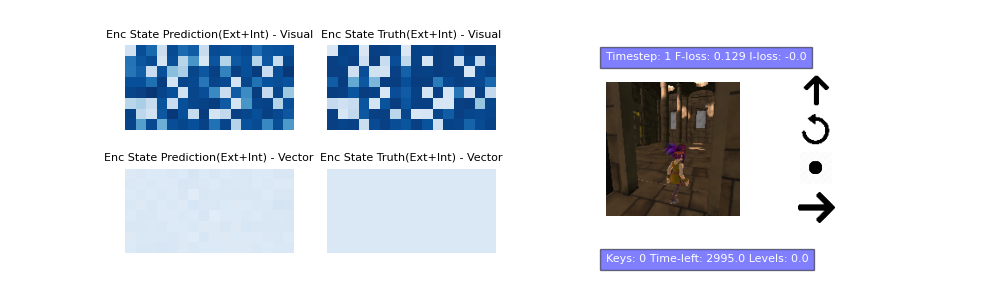
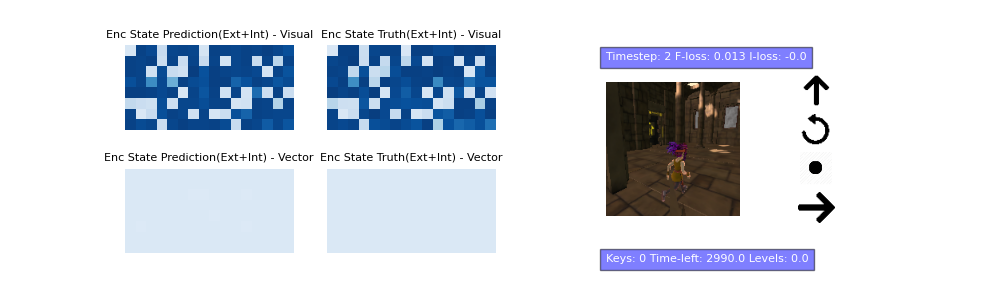
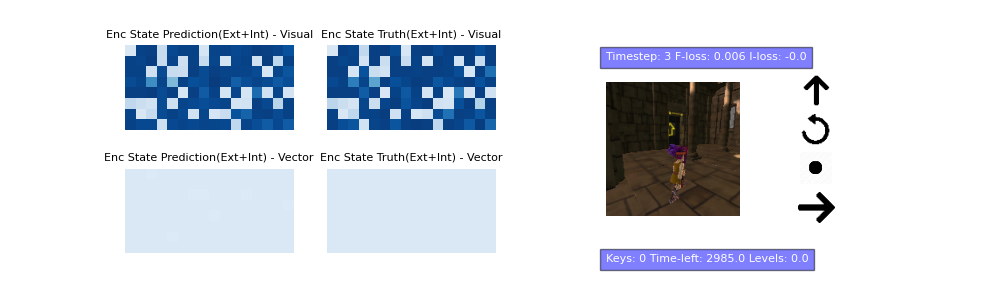
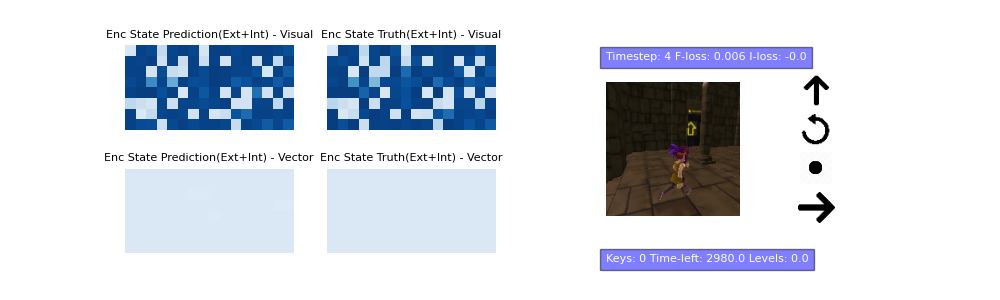
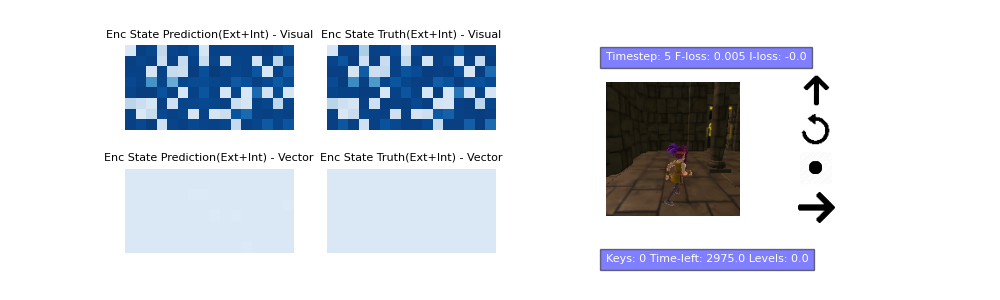
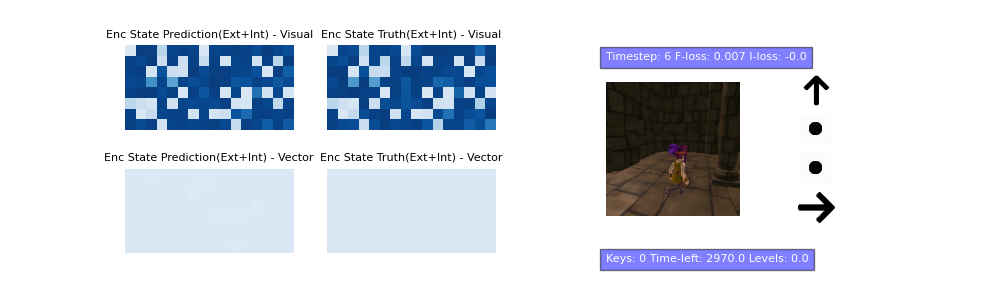
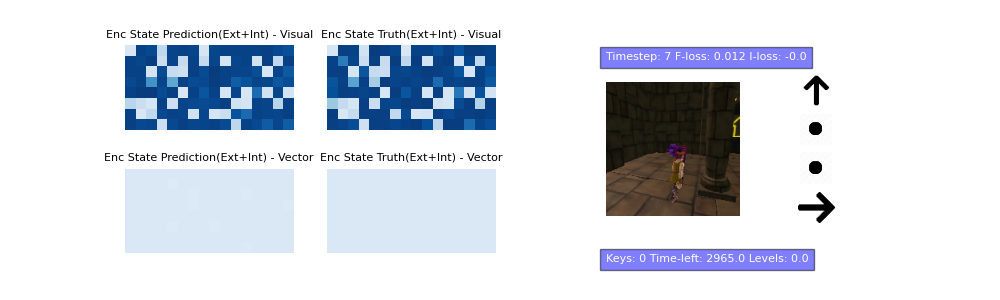
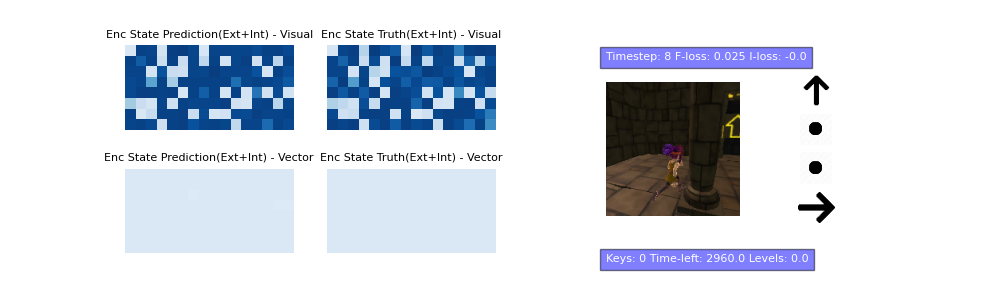
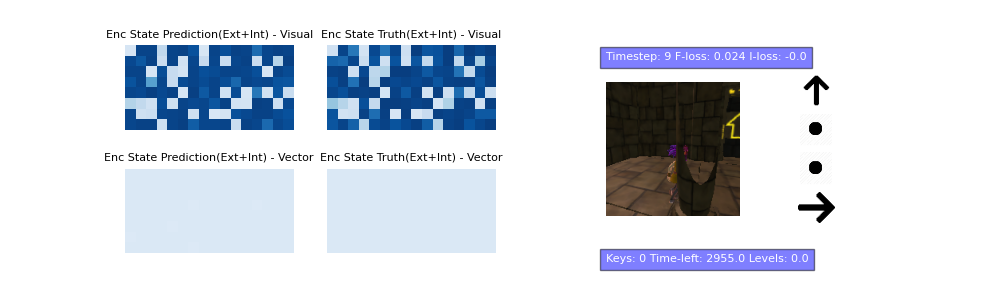
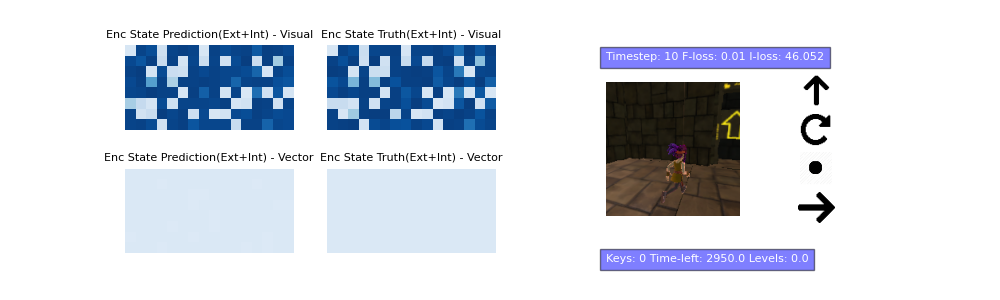
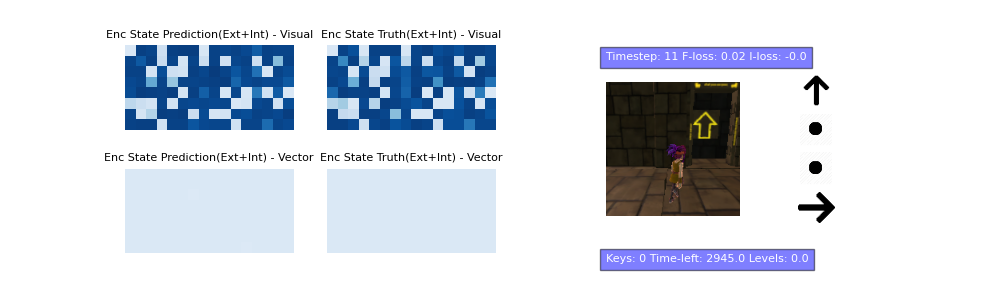
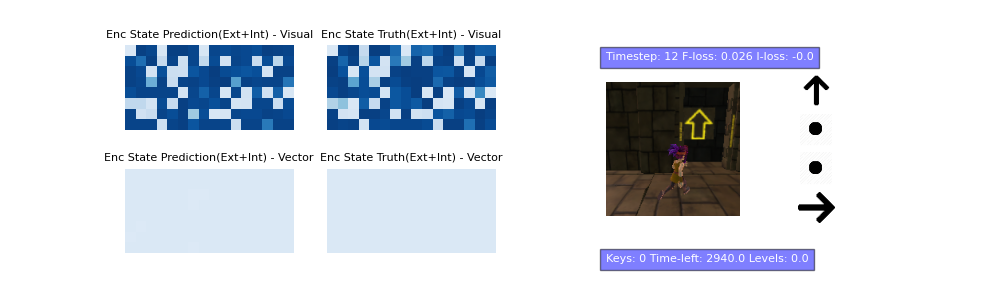
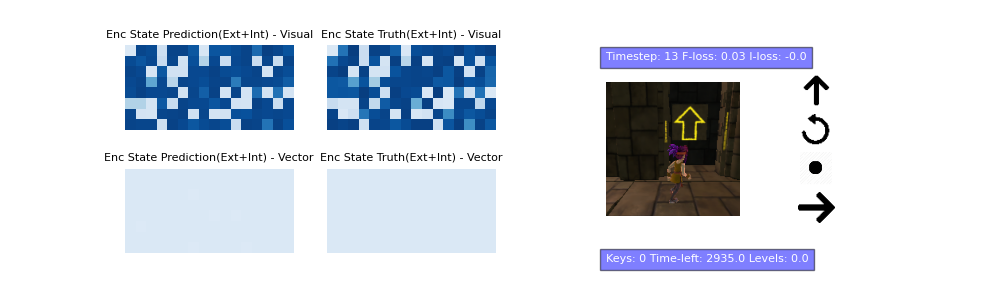
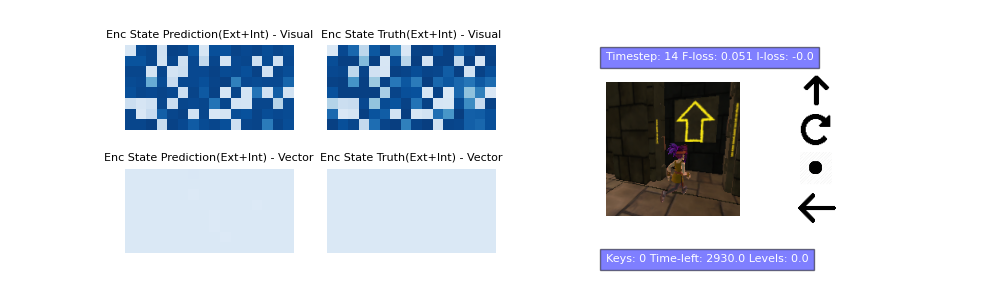
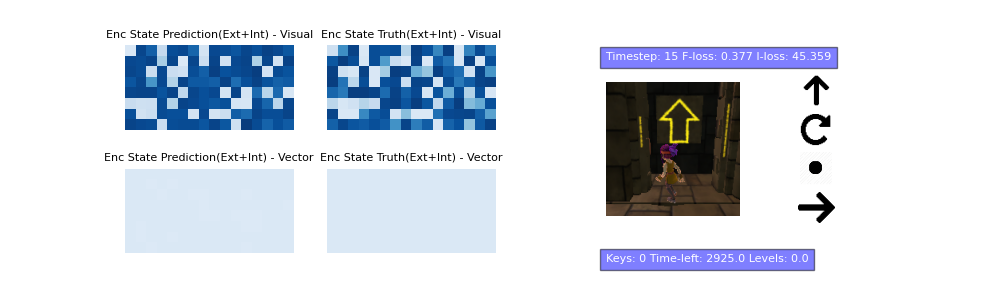
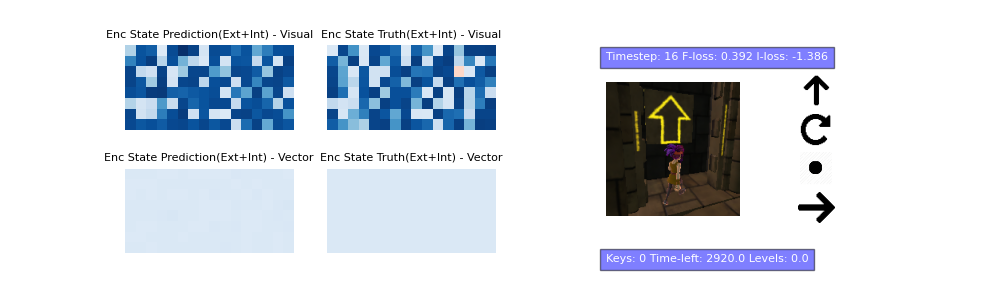
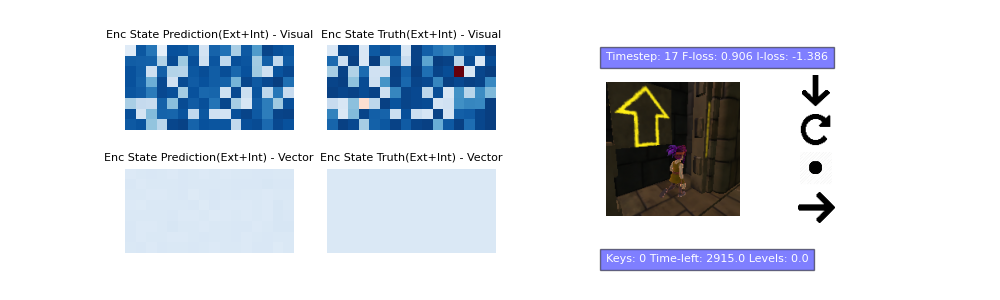
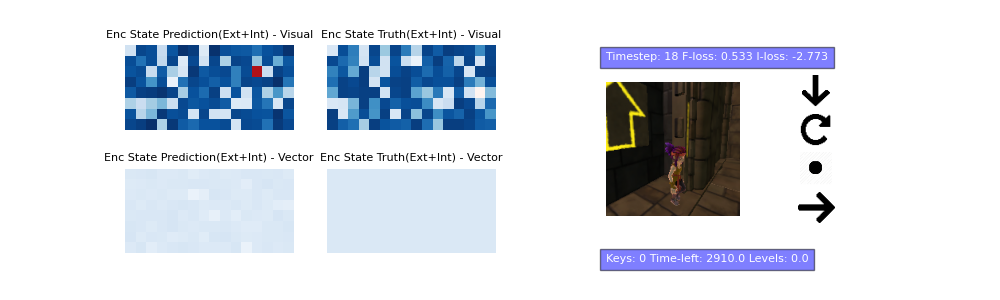
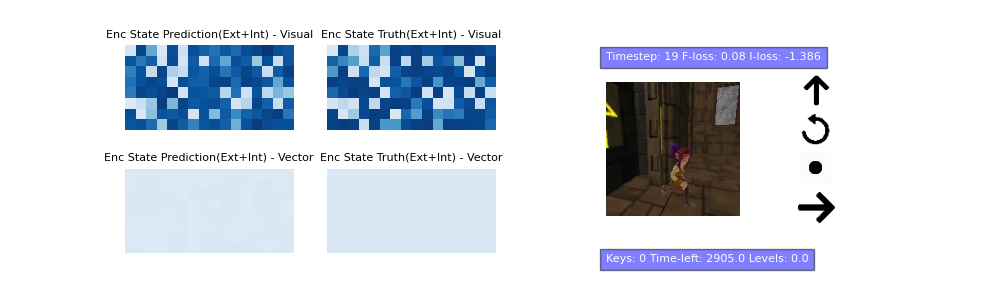
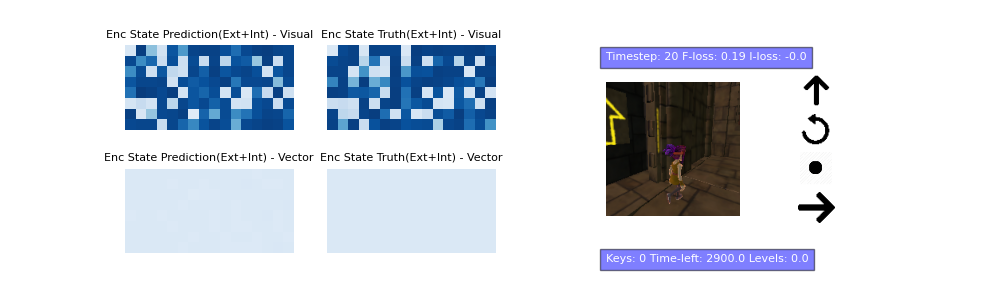
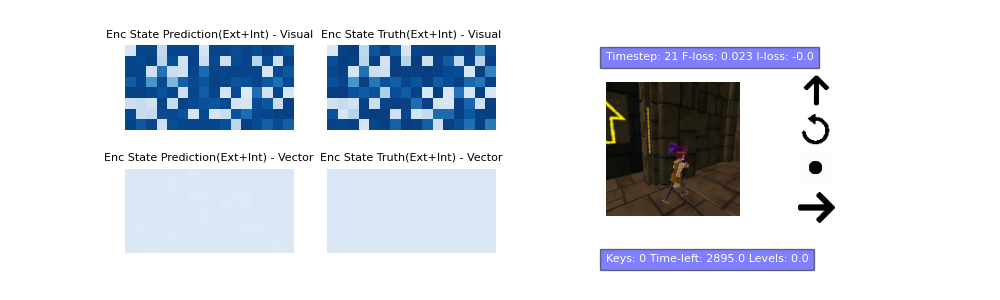
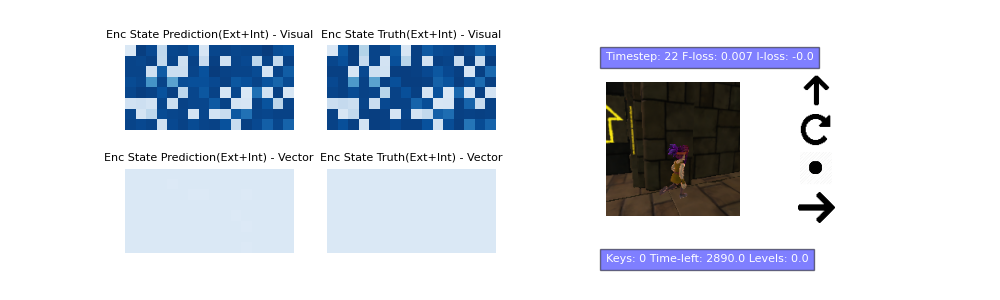
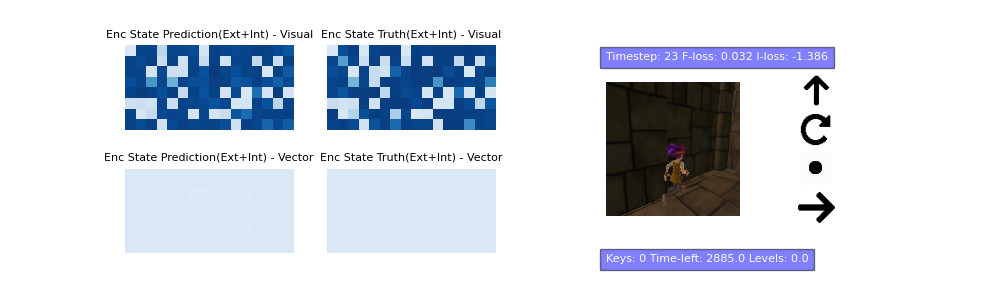
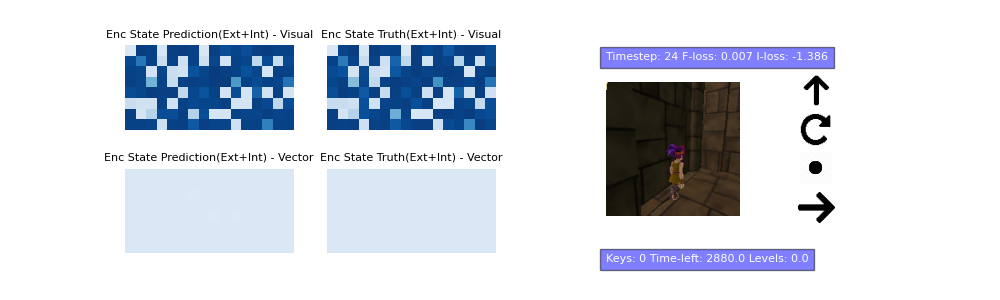
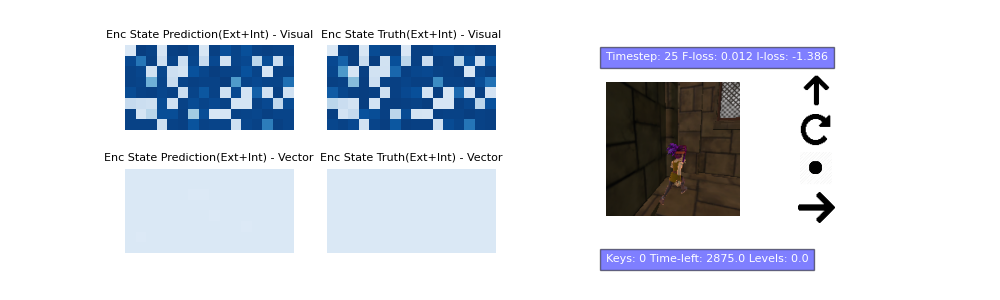
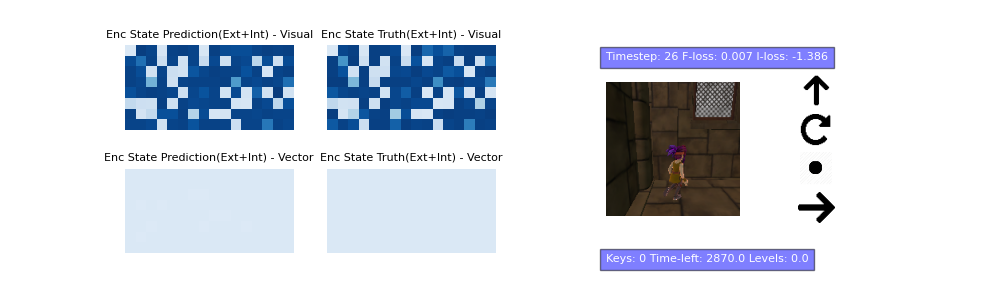
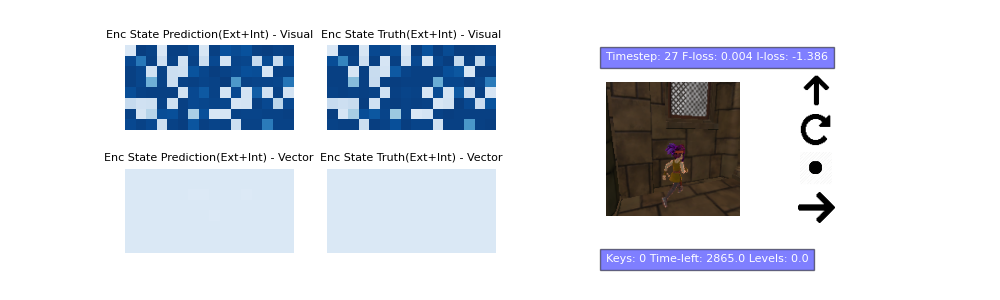
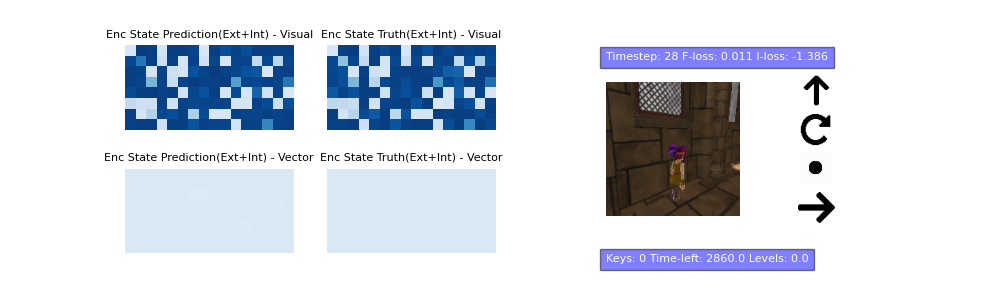
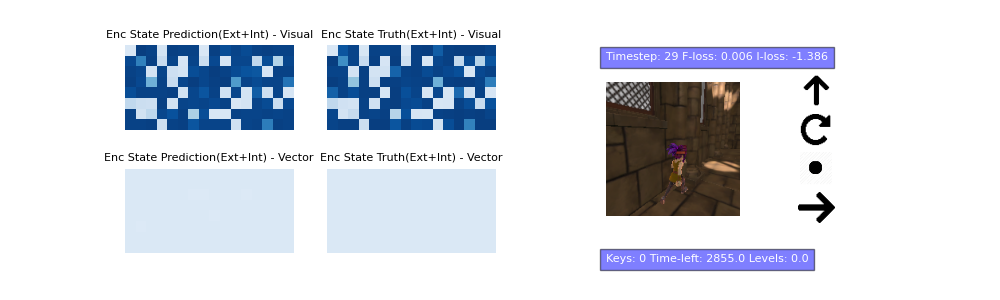
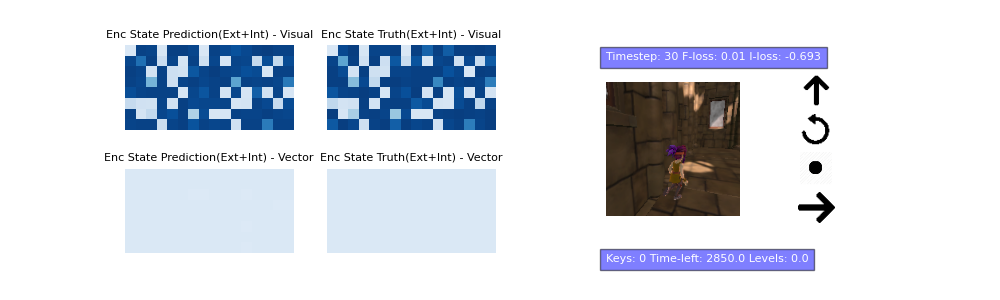
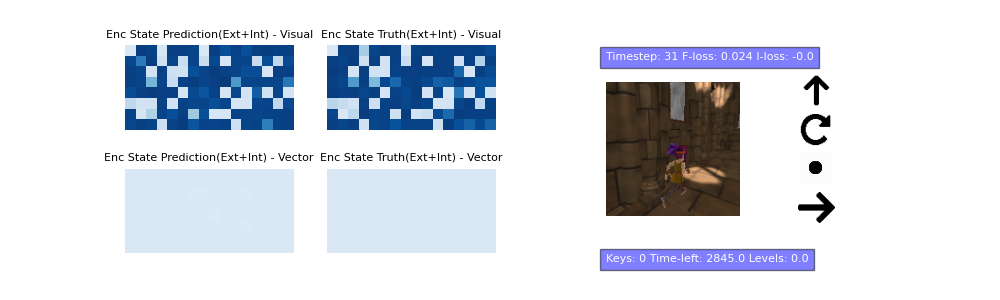
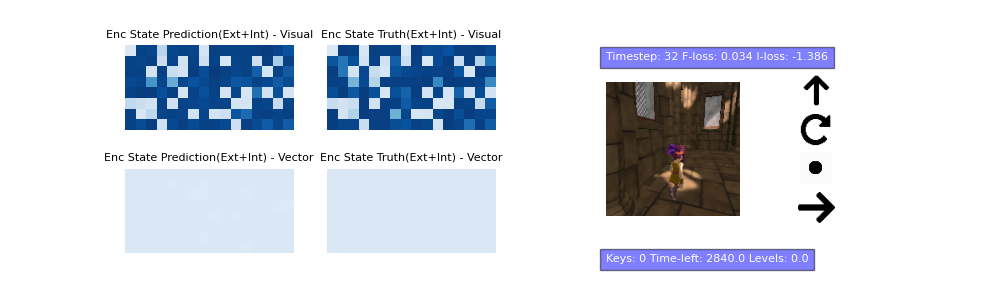
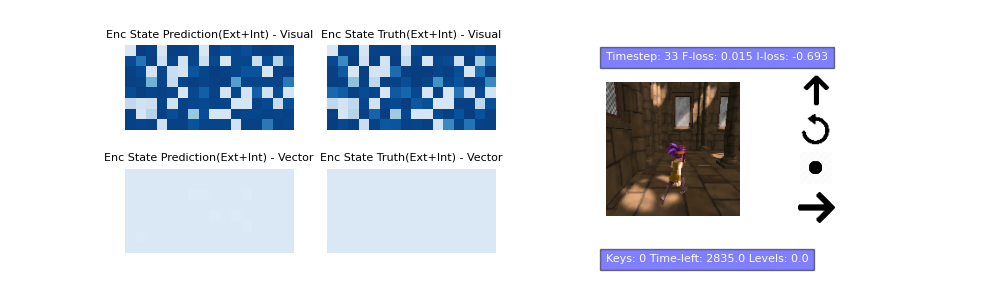
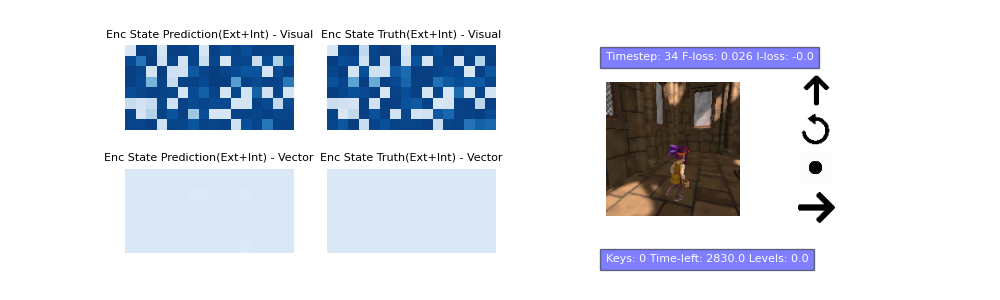
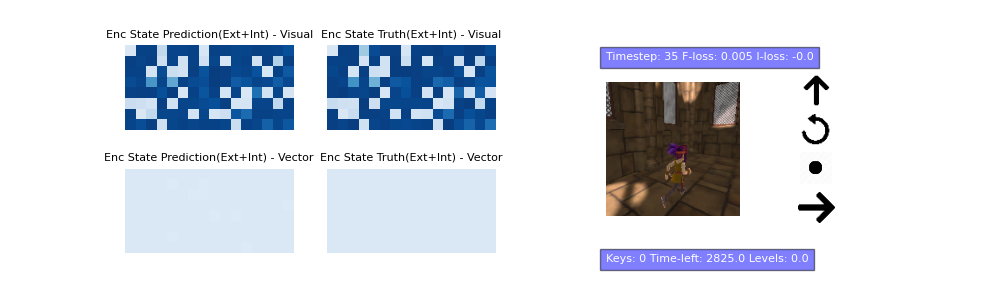
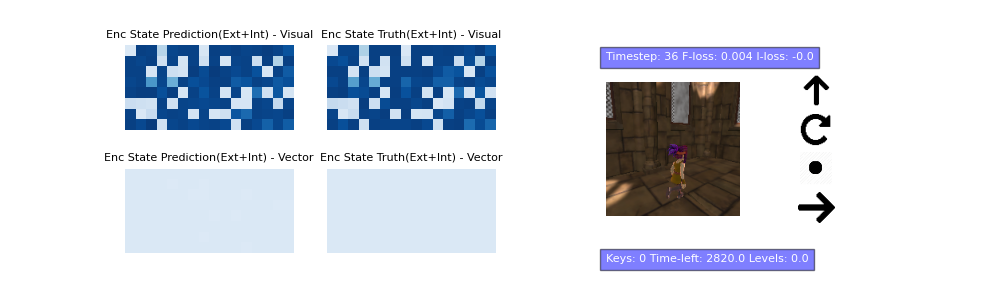
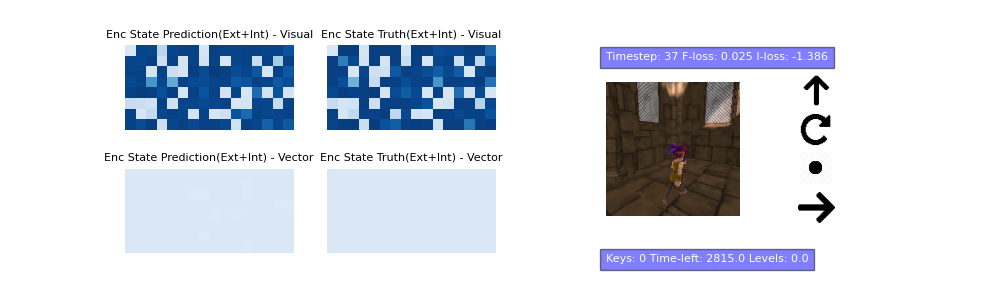
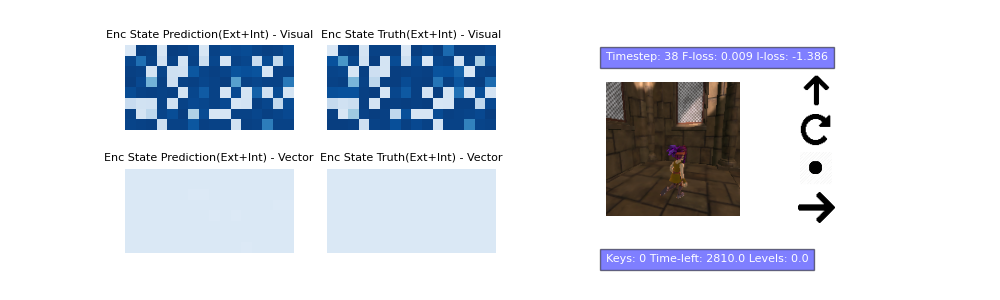
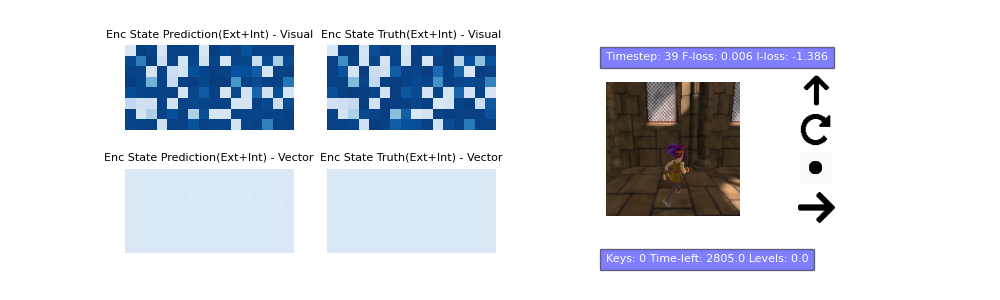
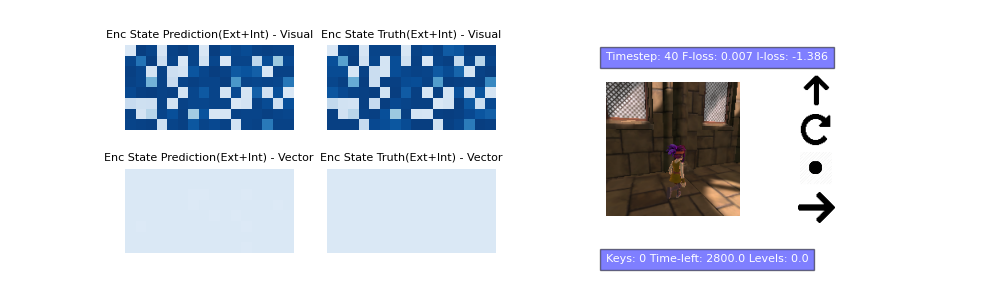
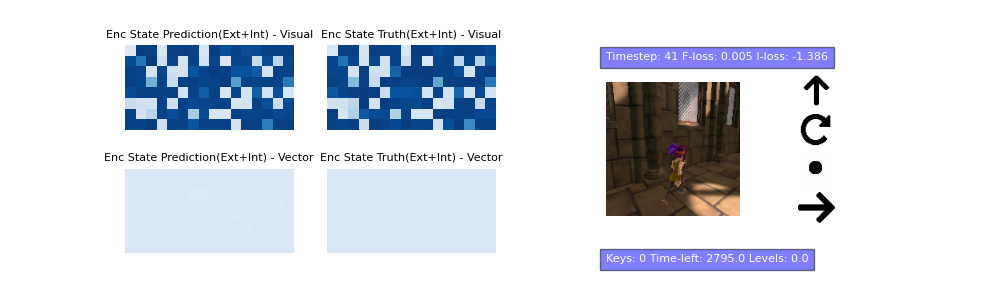
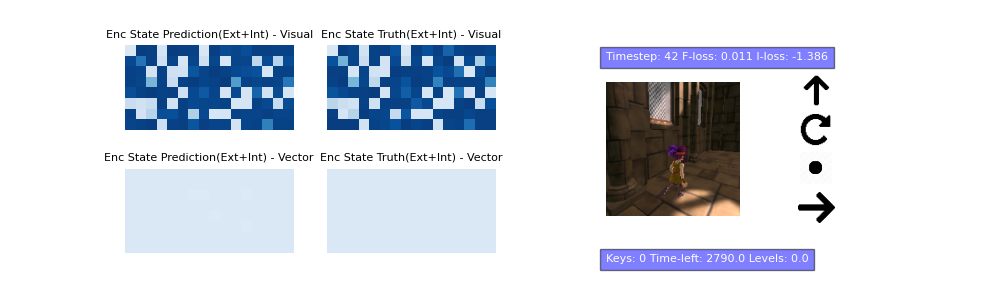
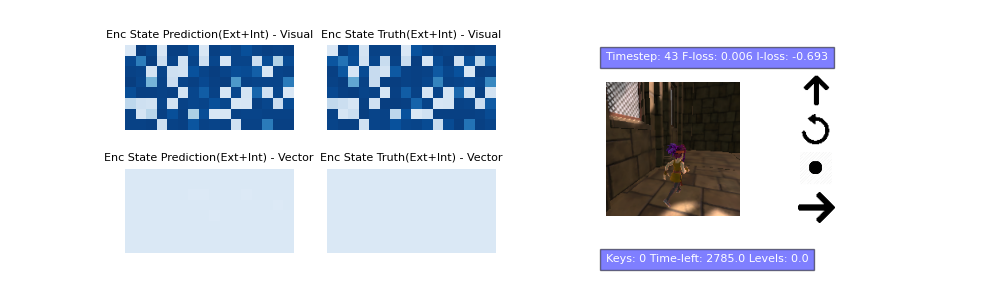
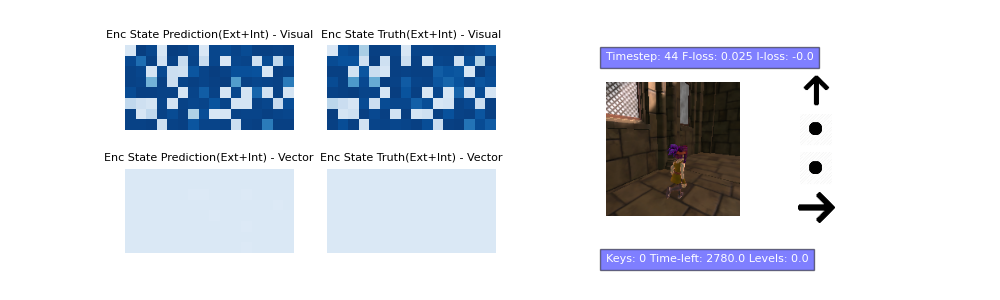
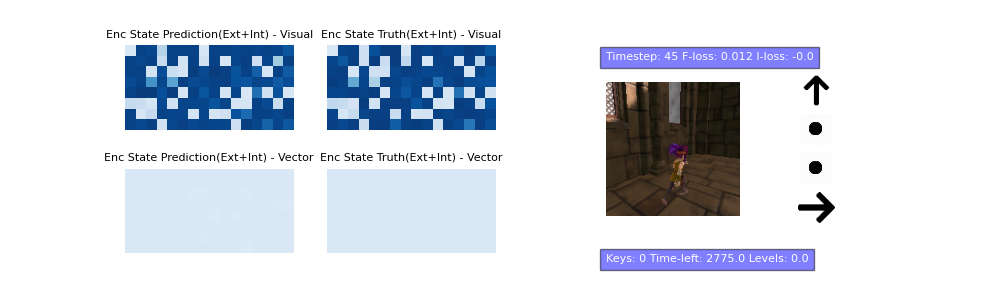
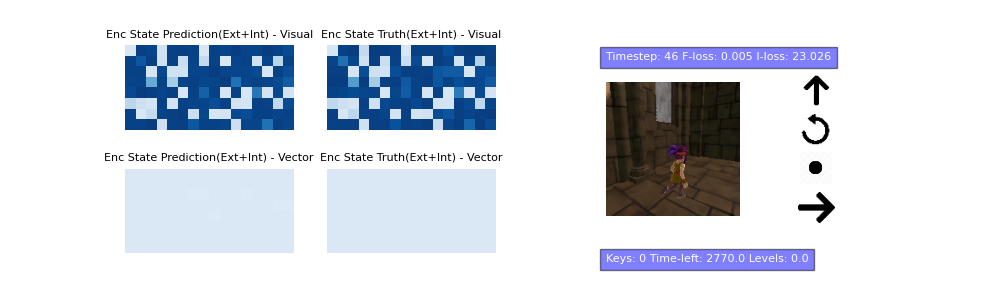
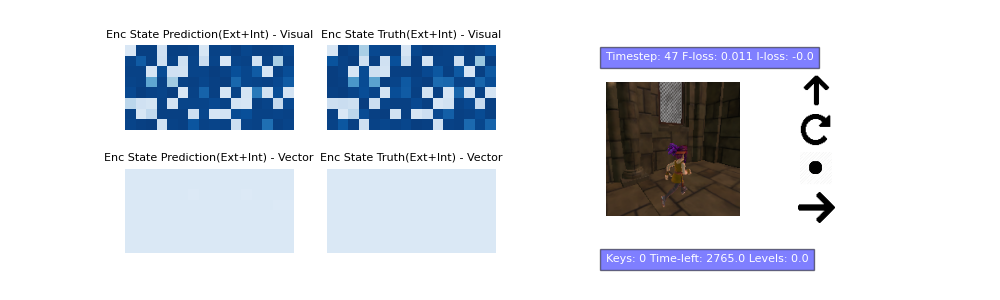
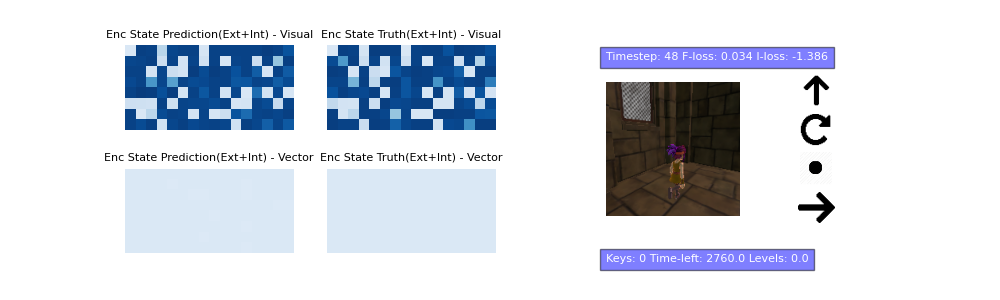
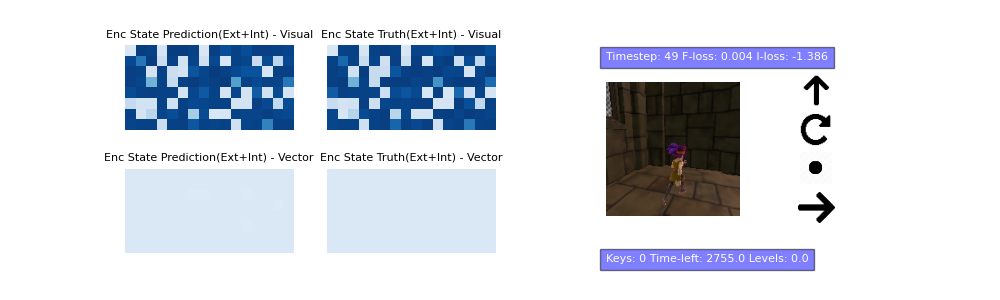
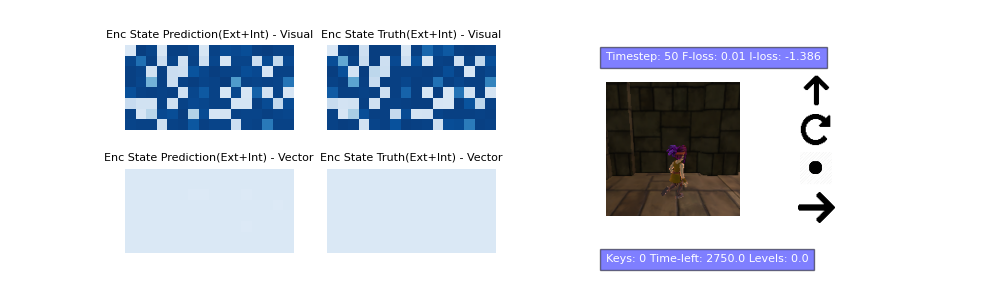

In [14]:
#colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
viridis = cm.get_cmap('viridis', 256)
def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()
    
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Reds', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')
# plot_examples([viridis, newcmp])

# Heatmap

def plot_movie_js_both(enc1_array,enc2_array,image_array,acts,start,save=None):
    #Shows encoding and frames
    fig = plt.figure(figsize=(10,3), dpi=100)
    
    #set dimension for visual and vector encoding
    dim = 8
    
    #set range
    vmin = -0.3
    vmax = 0.4
    
    cmaps = {}
#     https://matplotlib.org/stable/tutorials/colors/colormaps.html
    cmaps['Diverging'] = [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
    cmap = newcmp
#     cmaps['Diverging'][6]  #8


    

    
    ####
    
    ax1 = fig.add_subplot(2, 4, 1)
    plt.title('Enc State Prediction(Ext+Int) - Visual', fontsize=8)
    plt.axis('off')
    im = plt.imshow(enc1_array[0][:dim,:],vmin=vmin,vmax=vmax,cmap=cmap,norm=None) 
#     fig.colorbar(im)
    
    ax2 = fig.add_subplot(2, 4, 5)
    plt.title('Enc State Prediction(Ext+Int) - Vector', fontsize=8)
    plt.axis('off')
    im2 = plt.imshow(enc1_array[0][dim:,:],vmin=vmin,vmax=vmax,cmap=cmap,norm=None) 
#     fig.colorbar(im2)
    
    ax3 = fig.add_subplot(2, 4, 2)
    plt.title('Enc State Truth(Ext+Int) - Visual', fontsize=8)
    plt.axis('off')
    im3 = plt.imshow(enc2_array[0][:dim,:],vmin=vmin,vmax=vmax,cmap=cmap,norm=None) 
#     fig.colorbar(im3)
    
    ax4 = fig.add_subplot(2, 4, 6)
    plt.title('Enc State Truth(Ext+Int) - Vector', fontsize=8)
    plt.axis('off')
    im4 = plt.imshow(enc2_array[0][dim:,:],vmin=vmin,vmax=vmax,cmap=cmap,norm=None) 
#     fig.colorbar(im4)
    
    ax5 = fig.add_subplot(1, 5, 4)
#     ax5 = fig.add_subplot(1, 3, 3
    im5 = plt.imshow(image_array[0])
    plt.axis('off')
    
    ax6 = fig.add_subplot(8, 5, 4)
    im6 = plt.text(0.0,0.0,"Timestep: "+str(start+1)+" F-loss: "+str(forward_losses[start])+" I-loss: "+str(inverse_losses[start]),
                   fontsize=8,color='white', bbox=dict(facecolor='blue', alpha=0.5))
    plt.axis('off')
    
    
    ## VECTOR OBS
    ax11 = fig.add_subplot(8, 5, 39)
    im11 = plt.text(0.0,0.0,"Keys: "+str(keys[start])+" Time-left: "+str(time_left[start])+" Levels: "+str(levels[start]),
                   fontsize=8,color='white', bbox=dict(facecolor='blue', alpha=0.5))
    plt.axis('off')
    
    #### ACTIONS PLOT
    def getImage(act,num):
        if act==0:
            return stand
        if num==0:
            if act==1:
                return up
            if act==2:
                return down
        if num==1:
            if act==1:
                return turn_l
            if act==2:
                return turn_r
        if num==2 and act==1:
            return jump
        if num==3:
            if act==1:
                return right
            if act==2:
                return left
    
    jump = imageio.imread('./symbols/jump.png')
    left = imageio.imread('./symbols/arrow-left.png')
    right = imageio.imread('./symbols/arrow_right.png')
    down = imageio.imread('./symbols/down-arrow.png')
    up = imageio.imread('./symbols/up-arrow.png')
    turn_l = imageio.imread('./symbols/turn-left.png')
    turn_r = imageio.imread('./symbols/turn-right.png')
    stand = imageio.imread('./symbols/Stand.png')
    
    
    ax7 = fig.add_subplot(6, 4, 8)
    im7 = plt.imshow(getImage(acts[0][0][0],0))
    plt.axis('off')
    ax8 = fig.add_subplot(6, 4, 12)
    im8 = plt.imshow(getImage(acts[0][0][1],1))
    plt.axis('off')
    ax9 = fig.add_subplot(6, 4, 16)
    im9 = plt.imshow(getImage(acts[0][0][2],2))
    plt.axis('off')
    ax10 = fig.add_subplot(6, 4, 20)
    im10 = plt.imshow(getImage(acts[0][0][3],3))
    plt.axis('off')
    
    
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

    def animate(i):
        im.set_array(enc1_array[i][:dim,:])
        im2.set_array(enc1_array[i][dim:,:])
        im3.set_array(enc2_array[i][:dim,:])
        im4.set_array(enc2_array[i][dim:,:])
        im5.set_array(image_array[i])
        im6.set_text("Timestep: "+str(start+i+1)+" F-loss: "+str(np.round(forward_losses[start+i],3))
                     +" I-loss: "+str(np.round(inverse_losses[start+i],3)))
        
        ### ACTIONS PLOT
        im7.set_array(getImage(acts[i][0][0],0))
        im8.set_array(getImage(acts[i][0][1],1))
        im9.set_array(getImage(acts[i][0][2],2))
        im10.set_array(getImage(acts[i][0][3],3))
        
        #VECTOR obs
        im11.set_text("Keys: "+str(keys[start+i])+" Time-left: "+str(time_left[start+i])+" Levels: "+str(levels[start+i]))
        
        
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))

    display(IPython_display.display_animation(anim))
    if save!=None:
        anim.save(save, writer=writer)




obs = np.load('models\ext+int\\4000_0\\visobs.npy', mmap_mode='r')

# enc1 = np.load(path+'\encExtInt2.npy')
# enc2 = np.load(path+'\encInt2.npy')
enc1 = pred_next_states_ExtInt
enc1 = enc1.reshape(3999,256)
enc2 = curiosity_encoding_nextstate_ExtInt
enc2 = enc2.reshape(3999,256)

obs = obs[1:] #since starting from predicted state

# vec = np.load(path+'vecobs.npy')
# val = np.load(path+'\\values.npy')
# act = np.load(path+'\\actions.npy')
# rew = np.load(path+'\\rewards.npy')

# FOR EXT + INT 
reshape_dim1 = [16,16]

encodings1 = np.zeros((obs.shape[0],reshape_dim1[0],reshape_dim1[1]))
for i in range(obs.shape[0]):
    encodings1[i] = enc1[i].reshape((reshape_dim1[0],reshape_dim1[1])) 

# FOR ONLY INT
reshape_dim2 = [16,16]

encodings2 = np.zeros((obs.shape[0],reshape_dim2[0],reshape_dim2[1]))
for i in range(obs.shape[0]):
    encodings2[i] = enc2[i].reshape((reshape_dim2[0],reshape_dim2[1])) 
    
    

start = 0 
end = 50 #3998
# plot_movie_jsInfo(encodings[:end],obs[:end],act[:end],val[:end],rew[:end])#,save=path+'encodingsInfo.mp4')

plot_movie_js_both(encodings1[start:end],encodings2[start:end],obs[start:end],selected_action_ExtInt,start,save=figurePath+'/Curiosity_encodings_ExtInt_prediction_'+str(start)+'_to_'+str(end)+'.mp4')

In [34]:
len(inverse_losses)

3999

In [41]:
enc1.shape
all_colors = ['lime','royalblue','darkred','grey','purple']

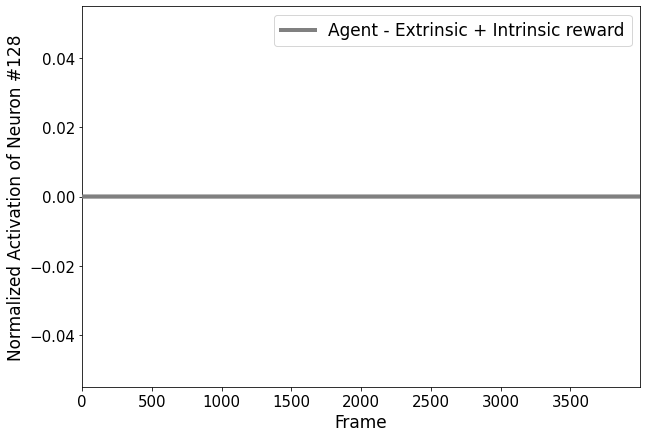

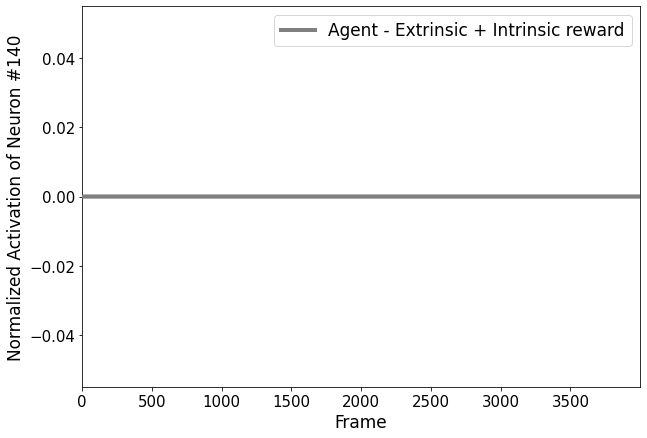

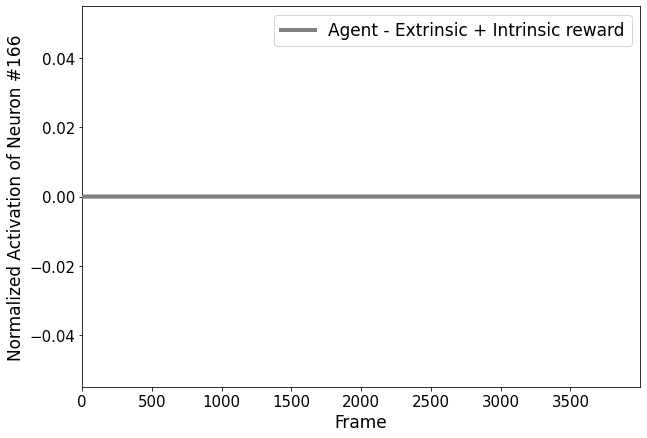

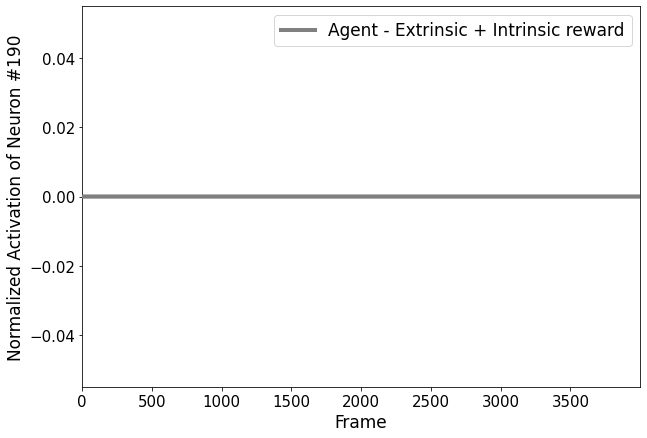

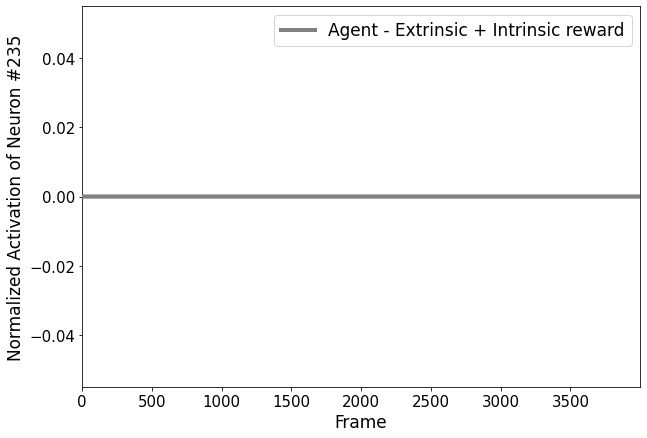

In [43]:
# after NEURON 128

# cur_state_Int = np.load('models\int\\3000_0\\\enc_cur_state.npy')
cur_state_ExtInt = cur_state_ExtInt.reshape(3999,256)


for n in [128,140,166,190,235]:
    plt.figure(figsize=(10,7))
    

    ysmoothedExtInt = gaussian_filter1d(cur_state_ExtInt[:,n], sigma=4)
    plt.plot(ysmoothedExtInt,color=all_colors[3],lw=4,zorder=4)
    
    plt.plot(cur_state_ExtInt[:,n],color=all_colors[3],lw=4,alpha=0.4)

    plt.xlim([0,3999])
    
    plt.legend(['Agent - Extrinsic + Intrinsic reward'],fontsize=17)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Frame',fontsize=17)
    plt.ylabel('Normalized Activation of Neuron #'+str(n),fontsize=17)
    plt.show()
    #plt.savefig(figurePath+'NeuronActs/ActN'+str(n)+'.jpeg', bbox_inches='tight', dpi=300)


In [56]:
cur_state_ExtInt = np.load('models\ext+int\\4000_0\\\enc_cur_state.npy')

for i in cur_state_ExtInt[:,128:256]:
    for j in i:
        if j!=0:
            print(j)

In [57]:
for i in pred_next_states_ExtInt[:,128:256]:
    for j in i:
        if j!=0:
            print(j)

In [62]:
pred_next_states_ExtInt.reshape(3999,256)[:,128:256]

array([[ 3.6050058e-03, -1.4839051e-03,  1.9868652e-03, ...,
         1.1204565e-03, -1.2012691e-03, -1.6434565e-03],
       [ 4.2838510e-05,  1.2546033e-04,  1.1245196e-04, ...,
         3.3712294e-04,  8.2183833e-05, -5.6342804e-05],
       [-1.2032688e-06,  1.9688532e-04,  8.8060182e-04, ...,
         4.6830345e-04,  7.0467388e-05,  2.9977073e-04],
       ...,
       [-1.9175000e-04,  1.5721656e-04, -1.9874889e-04, ...,
         6.4326450e-06,  3.4301163e-04,  2.2612646e-04],
       [-2.3768749e-04,  1.6576611e-04, -1.2909062e-04, ...,
         2.4581701e-04,  3.1570671e-06,  1.9337947e-04],
       [-4.6185777e-04,  2.3359992e-04,  2.0040257e-04, ...,
         6.7745615e-04,  6.9941953e-04,  4.4559024e-04]], dtype=float32)

In [64]:
cur_state_ExtInt.reshape(4000,256)[:,128:256]

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

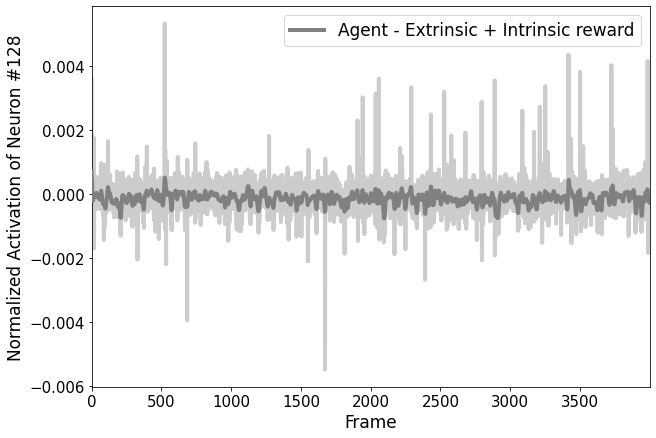

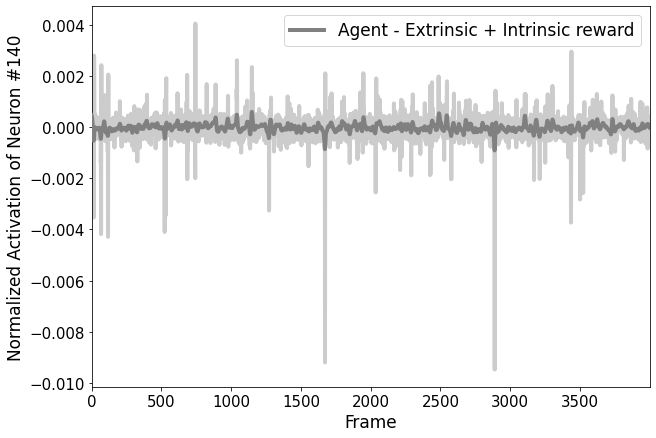

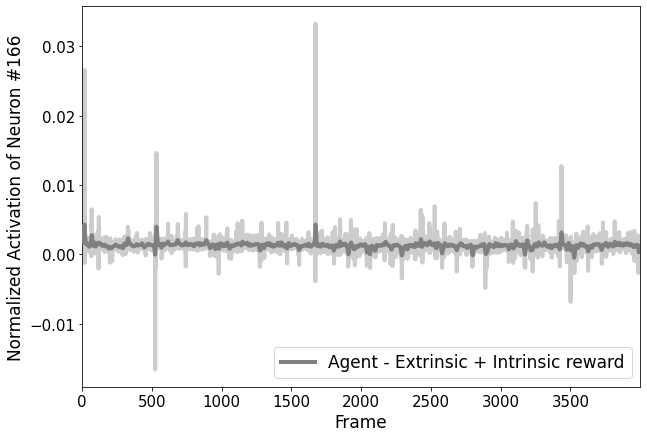

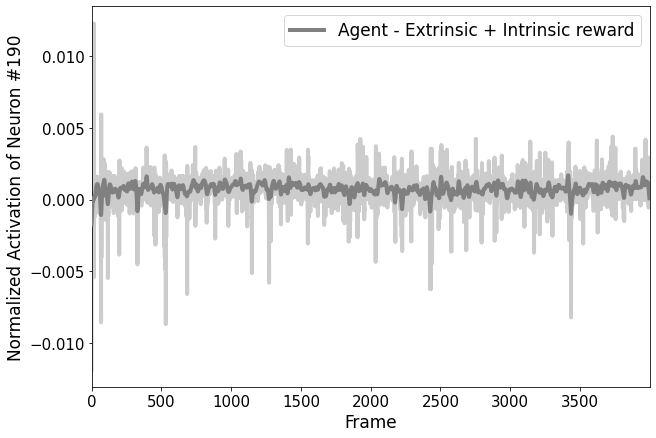

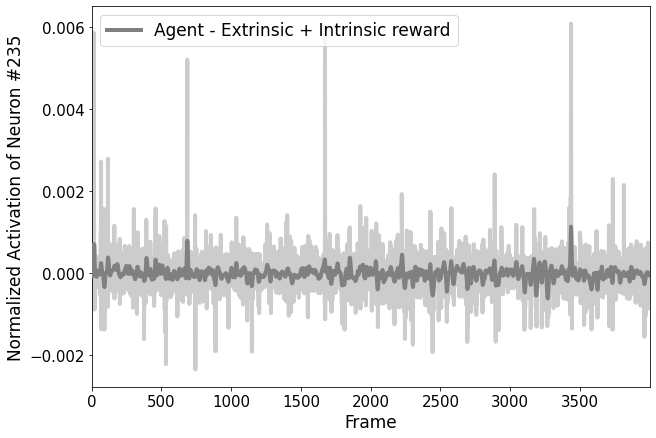

In [66]:
# after NEURON 128

# cur_state_Int = np.load('models\int\\3000_0\\\enc_cur_state.npy')
cur_state_ExtInt = pred_next_states_ExtInt.reshape(3999,256)


for n in [128,140,166,190,235]:
    plt.figure(figsize=(10,7))
    

    ysmoothedExtInt = gaussian_filter1d(cur_state_ExtInt[:,n], sigma=4)
    plt.plot(ysmoothedExtInt,color=all_colors[3],lw=4,zorder=4)
    
    plt.plot(cur_state_ExtInt[:,n],color=all_colors[3],lw=4,alpha=0.4)

    plt.xlim([0,3999])
    
    plt.legend(['Agent - Extrinsic + Intrinsic reward'],fontsize=17)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Frame',fontsize=17)
    plt.ylabel('Normalized Activation of Neuron #'+str(n),fontsize=17)
    plt.show()
    #plt.savefig(figurePath+'NeuronActs/ActN'+str(n)+'.jpeg', bbox_inches='tight', dpi=300)


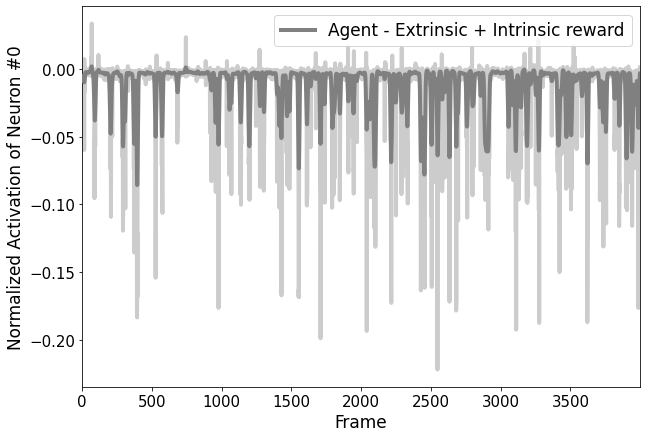

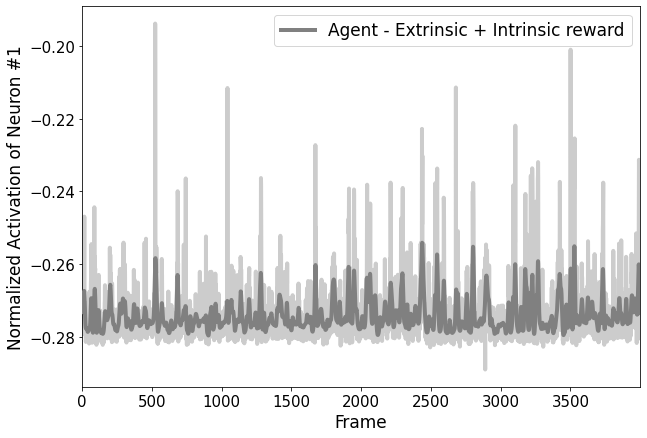

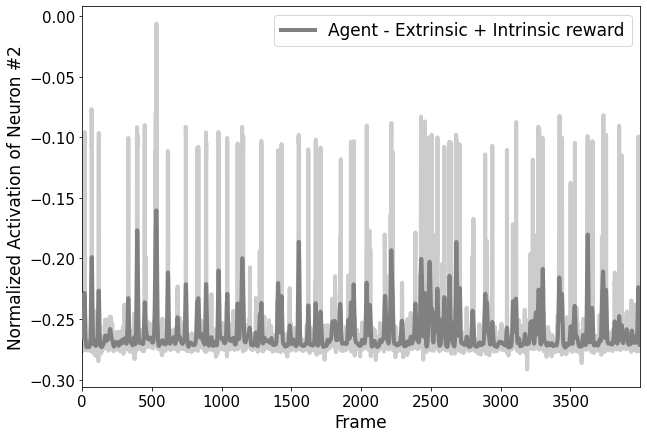

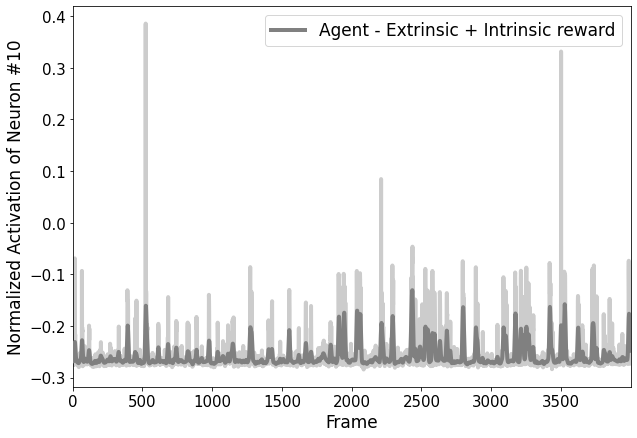

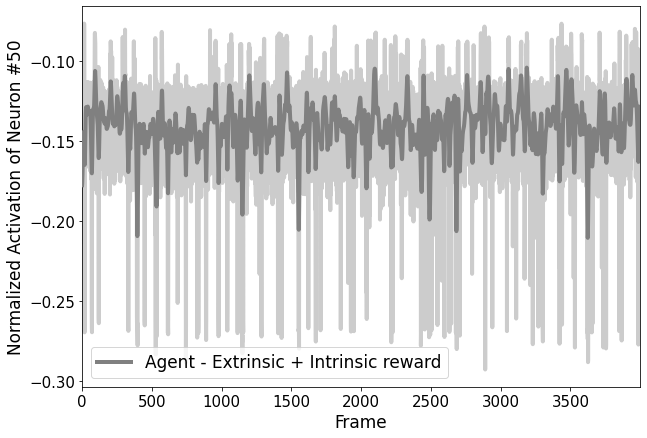

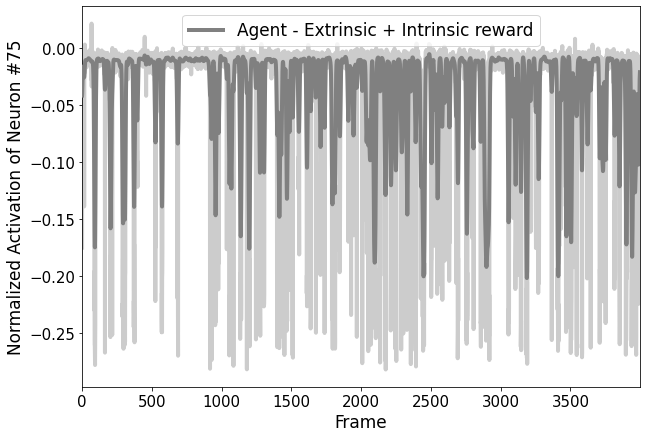

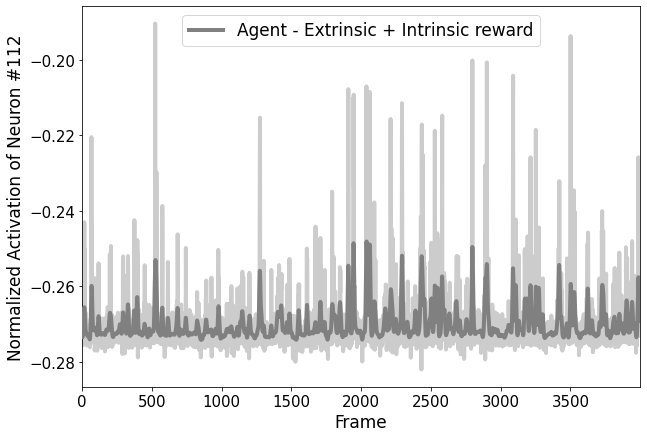

In [67]:
# before NEURON 128

# cur_state_Int = np.load('models\int\\3000_0\\\enc_cur_state.npy')
cur_state_ExtInt = pred_next_states_ExtInt.reshape(3999,256)


for n in [0,1,2,10,50,75,112]:
    plt.figure(figsize=(10,7))
    

    ysmoothedExtInt = gaussian_filter1d(cur_state_ExtInt[:,n], sigma=4)
    plt.plot(ysmoothedExtInt,color=all_colors[3],lw=4,zorder=4)
    
    plt.plot(cur_state_ExtInt[:,n],color=all_colors[3],lw=4,alpha=0.4)

    plt.xlim([0,3999])
    
    plt.legend(['Agent - Extrinsic + Intrinsic reward'],fontsize=17)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Frame',fontsize=17)
    plt.ylabel('Normalized Activation of Neuron #'+str(n),fontsize=17)
    plt.show()
    #plt.savefig(figurePath+'NeuronActs/ActN'+str(n)+'.jpeg', bbox_inches='tight', dpi=300)
